# Data Catalogue Analysis – TCIA

This notebook includes:

- Retrieving metadata from the TCIA API

- Comparing the available collections on the TCIA website vs. the TCIA API

- Visualizing the distribution of available collections via the TCIA API

- Obtaining a list of unique patient IDs (via the API), which can be used to query the Genomic Data Commons (GDC)

In [7]:
# Import libraries
from tcia_utils import nbia
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn2

## Retrieving metadata from the TCIA API

In [8]:
# See what data fields are availale
help(nbia.getSeries)

Help on function getSeries in module tcia_utils.nbia:

getSeries(collection='', patientId='', studyUid='', seriesUid='', modality='', bodyPart='', manufacturer='', manufacturerModel='', api_url='', format='')
    Gets Series (scan) metadata from a specified api_url.
    Allows filtering by collection, patient ID, study UID,
    series UID, modality, body part, manufacturer & model.



In [ ]:
# Get all the metadata available in TCIA to a python dataframe
# THIS MIGHT TAKE ~5 minutes to run
# DO NOT specify any data fields if you want to get AAAALLL the available data
df = nbia.getSeries(
                    # collection='',
                    # patientId='', 
                    # studyUid='', 
                    # seriesUid='', 
                    # modality='', 
                    # bodyPart='', 
                    # manufacturer='', 
                    # manufacturerModel='', 
                    # api_url='', 
                    format='df'
                    )

# save the dataframe so that you won't need to run this again
df.to_pickle("data_catalogue_tcia_api.pkl")

2025-11-20 11:57:49,156:INFO:Calling getSeries with parameters {}


In [9]:
# load python data dictionary
df_api = pd.read_pickle("data_catalogue_tcia_api.pkl")

In [10]:
# Have a peek at the data
print(len(df_api)) #length of the dataframe
print(df_api.columns) # column names
print(df_api.head()) #view first 4 rows of the dataframe

332024
Index(['SeriesInstanceUID', 'StudyInstanceUID', 'Modality', 'SeriesDate',
       'SeriesDescription', 'BodyPartExamined', 'SeriesNumber', 'Collection',
       'Site', 'PatientID', 'PatientSex', 'PatientAge', 'Manufacturer',
       'ManufacturerModelName', 'SoftwareVersions', 'ImageCount',
       'MaxSubmissionTimestamp', 'LicenseName', 'LicenseURI',
       'DataDescriptionURI', 'FileSize', 'DateReleased', 'StudyDesc',
       'StudyDate', 'Authorized', 'ReleasedStatus', 'ThirdPartyAnalysis',
       'ProtocolName', 'AdmittingDiagnosisDescription', 'AnnotationsFlag'],
      dtype='object')
                                   SeriesInstanceUID  \
0  1.3.6.1.4.1.14519.5.2.1.7695.1700.130662782053...   
1  1.3.6.1.4.1.14519.5.2.1.7695.1700.210410189256...   
2  1.3.6.1.4.1.14519.5.2.1.7695.1700.300426672774...   
3  1.3.6.1.4.1.14519.5.2.1.7695.1700.121675024518...   
4  1.3.6.1.4.1.14519.5.2.1.7695.1700.228597508795...   

                                    StudyInstanceUID Modality 

# Comparing the available collections on the TCIA website vs. the TCIA API

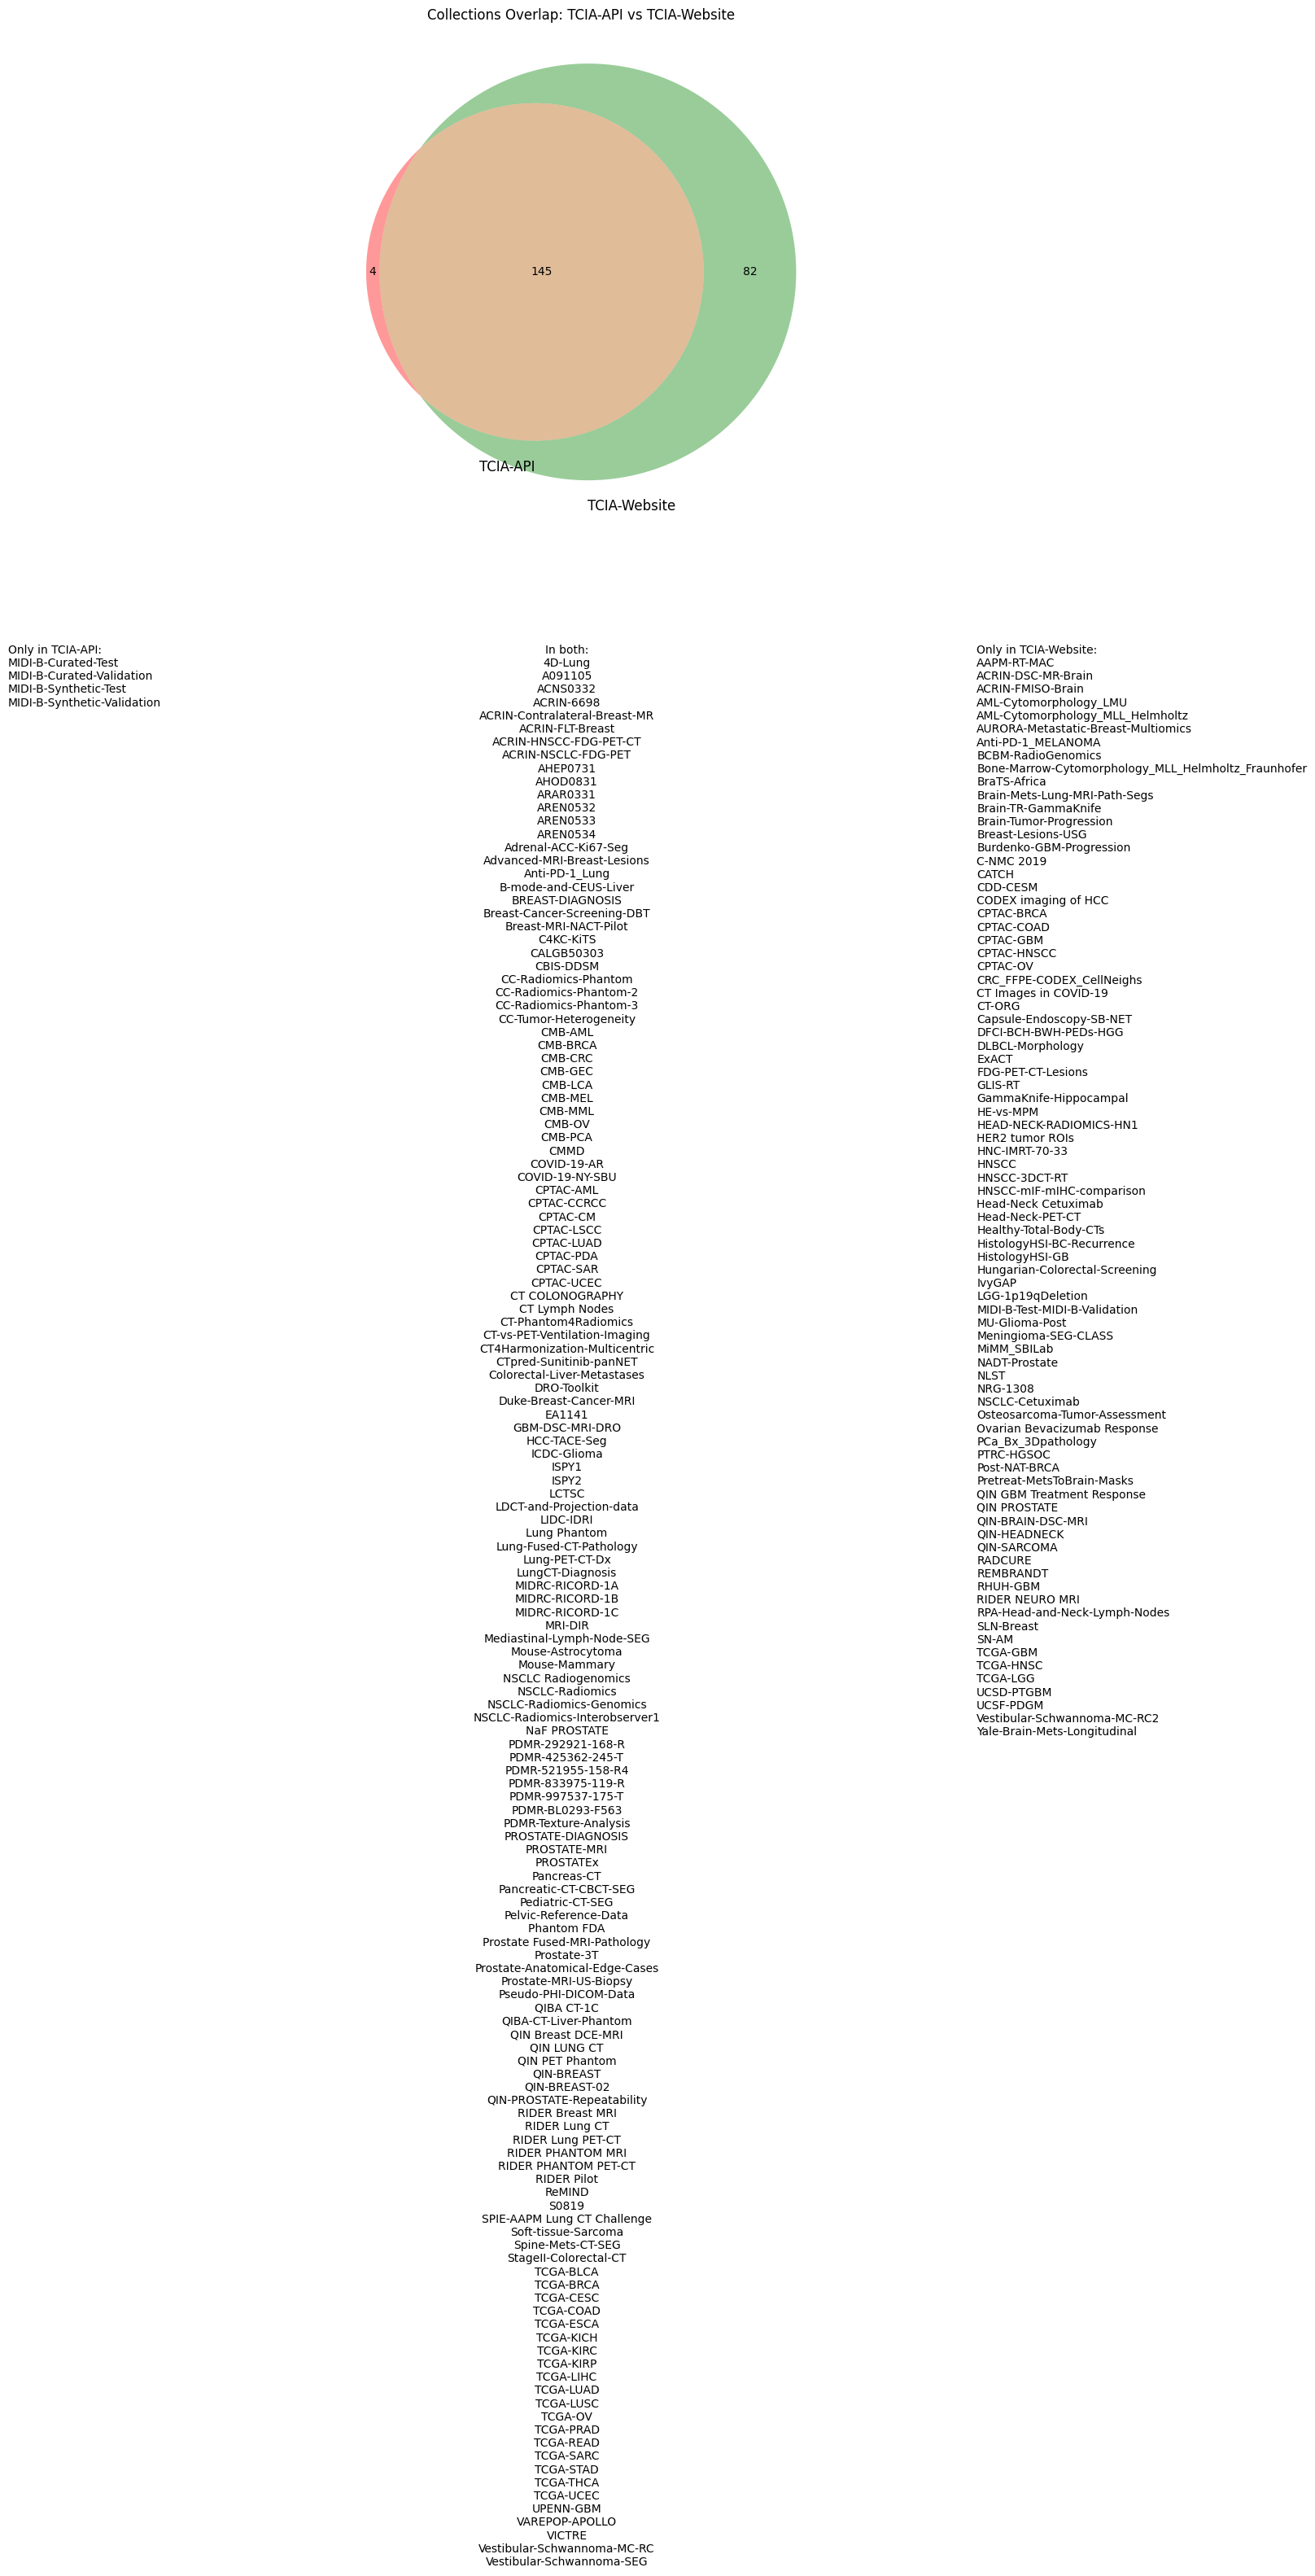

In [11]:
# Load TCIA metadata copies from the website
df_web = pd.read_excel("data_catalogue_tcia_web.xlsx")

# Create Venn diagram to see which collections are there in the API and Website
u1 = set(df_api['Collection'].unique())   # TCIA-API
u2 = set(df_web['Collection'].unique())  # TCIA-Website

plt.figure(figsize=(8,8))
venn2([u1, u2], set_labels=('TCIA-API', 'TCIA-Website'))
plt.title('Collections Overlap: TCIA-API vs TCIA-Website')
only_api = sorted(u1 - u2)
only_web = sorted(u2 - u1)
both = sorted(u1 & u2)
plt.text(-1.5, -1.0, "Only in TCIA-API:\n" + "\n".join(only_api), fontsize=10, verticalalignment='top')
plt.text(1.1, -1.0, "Only in TCIA-Website:\n" + "\n".join(only_web), fontsize=10, verticalalignment='top')
plt.text(0, -1.0, "In both:\n" + "\n".join(both), fontsize=10, verticalalignment='top', horizontalalignment='center')
plt.axis('off')  # optional, hide axes
plt.show()

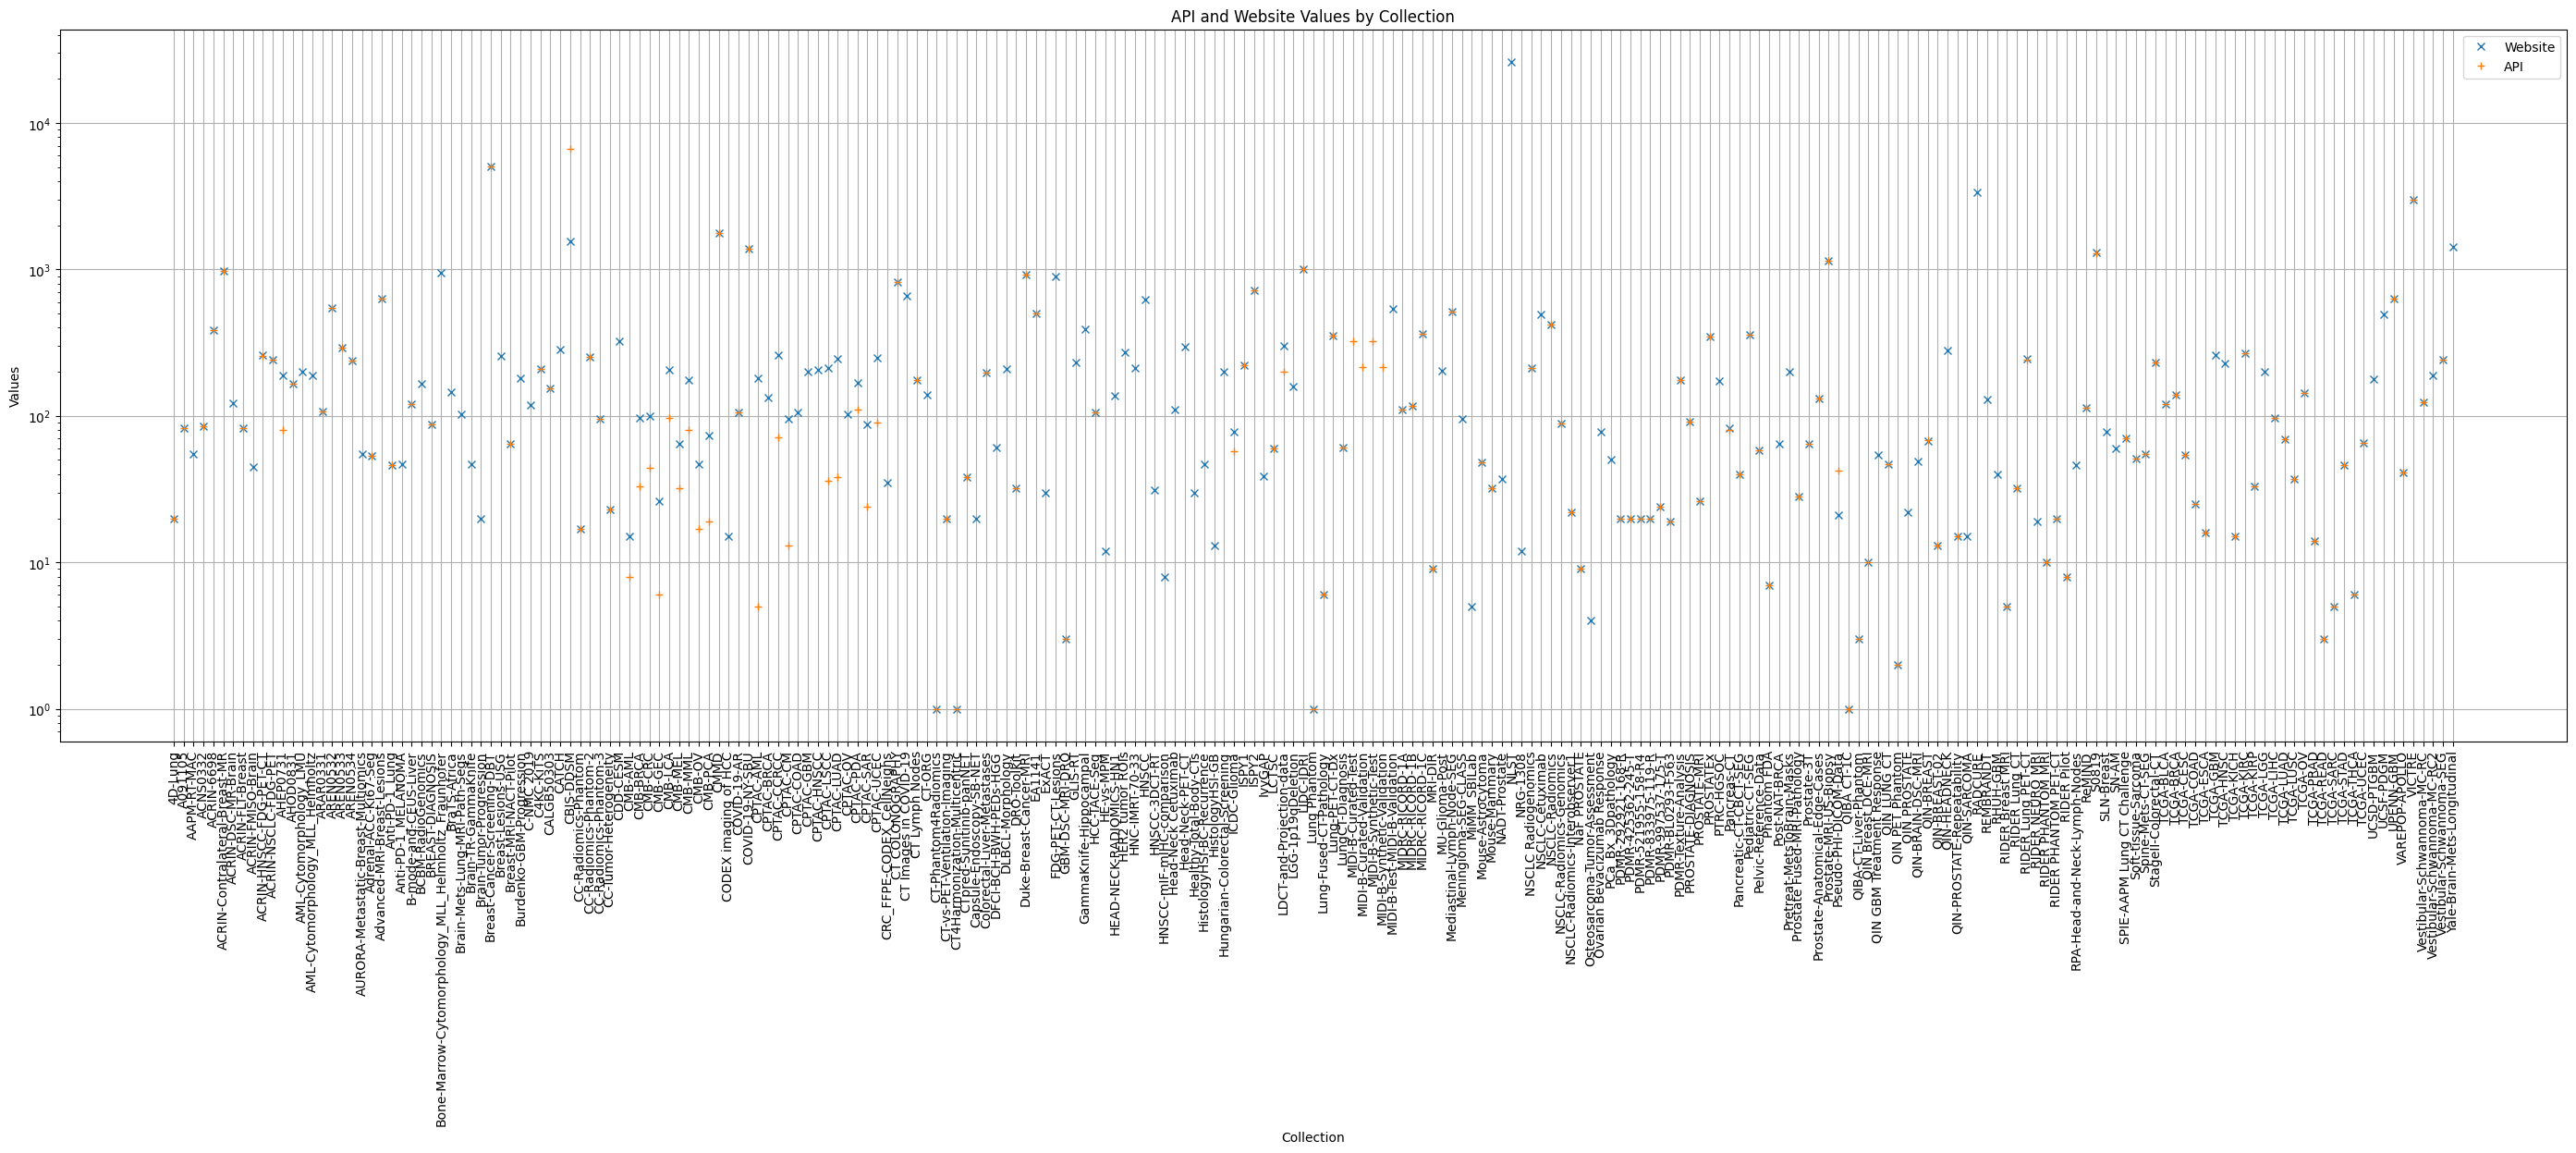

In [ ]:
# Let's compare the metadata (unique patient numbers) from API and Website
master_collection_list = list(set(df_api['Collection'].unique()) | set(df_web['Collection'].unique()))

count=0
compare = pd.DataFrame(columns=['Collection', 'API', 'Website'])
for collection in sorted(master_collection_list):
        filtered_df = df_api[df_api['Collection'] == collection]
        n = filtered_df['PatientID'].nunique()
        try:
                m = df_web.loc[df_web['Collection'] == collection, 'Subjects'].values[0]
        except:
                m = 0

        if n==0:
                n = None
        if m==0:
                m = None
        
        compare = pd.concat([compare, pd.DataFrame({'Collection':[collection], 'API':[n], 'Website':[m]})], ignore_index=True)


plt.figure(figsize=(35,10))
plt.plot(compare['Collection'], compare['Website'], marker='x', linestyle='', label='Website')
plt.plot(compare['Collection'], compare['API'], marker='+', linestyle='', label='API')

plt.xlabel('Collection')
plt.ylabel('Values')
plt.yscale('log')  # <-- set log scale

plt.xticks(rotation=90)
plt.title('API and Website Values by Collection')
plt.legend()
plt.grid(True)

# plt.savefig('api_website_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

# Visualizing the distribution of available collections via the TCIA API

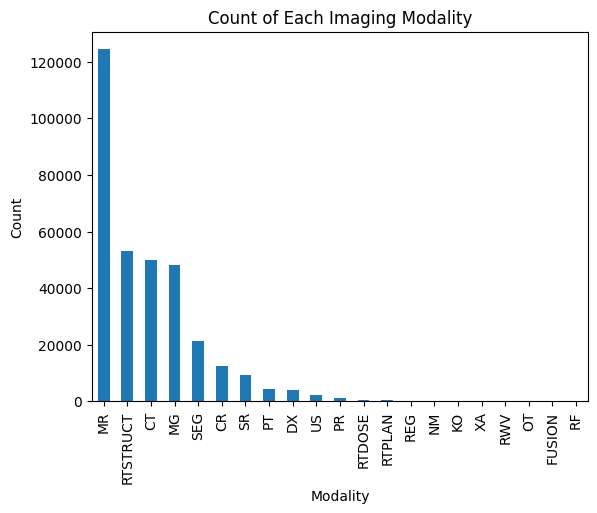

    Modality   Count
0         MR  124392
1   RTSTRUCT   53299
2         CT   49863
3         MG   48251
4        SEG   21269
5         CR   12542
6         SR    9473
7         PT    4309
8         DX    3836
9         US    2362
10        PR    1086
11    RTDOSE     524
12    RTPLAN     484
13       REG      97
14        NM      95
15        KO      40
16        XA      34
17       RWV      20
18        OT      18
19    FUSION      18
20        RF      12


In [13]:
# See what imaging modalities are available and how much
modality_counts = df_api['Modality'].value_counts().reset_index()
df_api['Modality'].value_counts().plot(kind='bar', title='Count of Each Imaging Modality')
plt.xlabel('Modality'); plt.ylabel('Count'); plt.show()
modality_counts.columns = ['Modality', 'Count']
print(modality_counts)

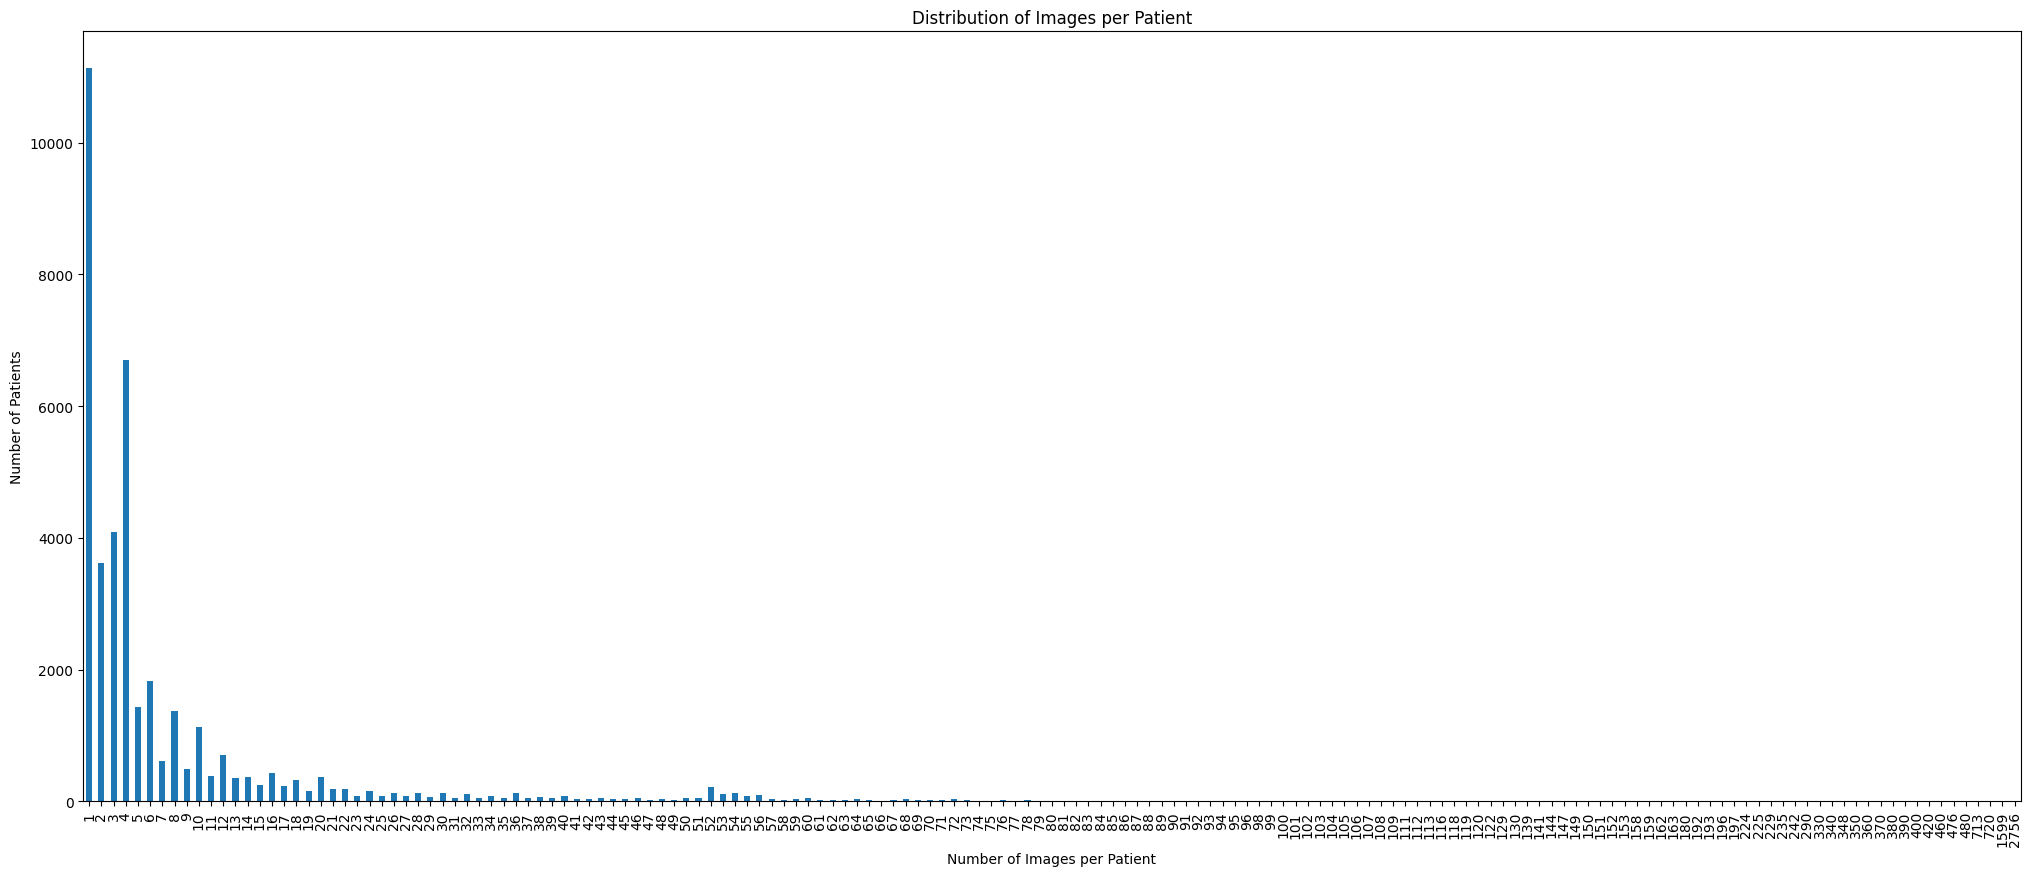

     num_images  num_patients
0             1         11132
1             2          3612
2             3          4090
3             4          6707
4             5          1438
..          ...           ...
154         480             1
155         713             1
156         720             4
157        1599             1
158        2756             1

[159 rows x 2 columns]


In [28]:
# See how many images are available per patient
counts = df_api.groupby('PatientID').size()

plt.figure(figsize=(25,10))
counts.value_counts().sort_index().plot(kind='bar', title='Distribution of Images per Patient')
plt.xlabel('Number of Images per Patient'); plt.ylabel('Number of Patients'); plt.show()

distribution_table = counts.value_counts().sort_index().reset_index()
distribution_table.columns = ['num_images', 'num_patients']
print(distribution_table)

In [15]:
# Seemed some patients have more than 1000 images, which is suspicious!!! Let's check.
counts = df_api.groupby('PatientID').size()
patients_over_1000 = counts[counts > 1000]
print(patients_over_1000) # Seems like they are phantoms!!!

PatientID
CT4Harmonization-Multicentric    2756
QIBA_CT_1C                       1599
dtype: int64


   Number of Unique Modalities  Number of Patients
0                            1               30178
1                            2                7008
2                            3                1845
3                            4                 581
4                            5                  62
5                            6                   2


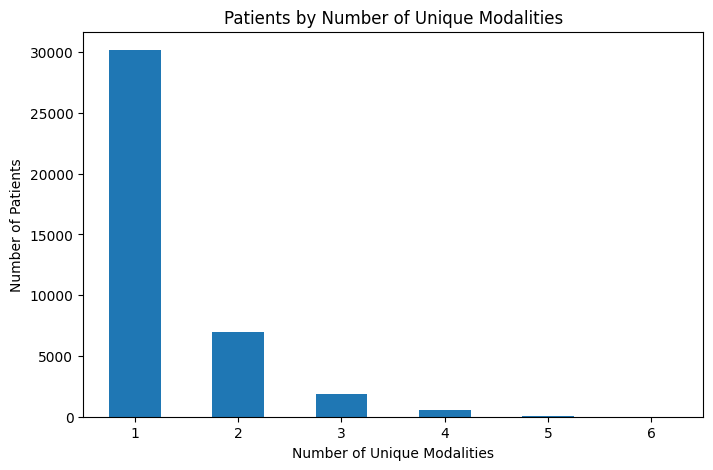

In [16]:
# See how many unique imaging modalities are available per patient
dist = df_api.groupby('PatientID')['Modality'].nunique().value_counts().sort_index()
table = dist.reset_index()
table.columns = ['Number of Unique Modalities', 'Number of Patients']
print(table)

dist.plot(kind='bar', title='Patients by Number of Unique Modalities', figsize=(8,5))
plt.xlabel('Number of Unique Modalities'); plt.ylabel('Number of Patients'); plt.xticks(rotation=0)
plt.show()

In [17]:
# One step further - see what combinations of modalities are common by patient
patient_modalities = df_api.groupby('PatientID')['Modality'].apply(lambda x: tuple(sorted(x.unique())))
num_modalities = patient_modalities.apply(len)
dist = num_modalities.value_counts().sort_index().reset_index()
dist.columns = ['Number of Unique Modalities', 'Number of Patients']
combo_counts = patient_modalities.value_counts().reset_index()
combo_counts.columns = ['Combination', 'Count']
def top_n_combinations(n, N=5):
    combos = combo_counts[combo_counts['Combination'].apply(len) == n]
    top_combos = combos.sort_values('Count', ascending=False).head(N)['Combination'].tolist()
    top_combos += [()] * (N - len(top_combos))
    return top_combos
top_cols = ['Top 1', 'Top 2', 'Top 3', 'Top 4', 'Top 5']
dist[top_cols] = dist['Number of Unique Modalities'].apply(lambda x: pd.Series(top_n_combinations(x)))
print(dist)

   Number of Unique Modalities  Number of Patients  \
0                            1               30178   
1                            2                7008   
2                            3                1845   
3                            4                 581   
4                            5                  62   
5                            6                   2   

                            Top 1                        Top 2  \
0                           (MG,)                        (MR,)   
1                       (MR, SEG)                    (CT, SEG)   
2                   (CT, SEG, SR)          (CT, RTSTRUCT, SEG)   
3  (MR, RTDOSE, RTPLAN, RTSTRUCT)            (CT, DX, SEG, SR)   
4     (CT, PR, RTSTRUCT, SEG, SR)  (CT, MR, PT, REG, RTSTRUCT)   
5       (CR, CT, DX, PR, SEG, SR)                           ()   

                   Top 3                   Top 4                 Top 5  
0                  (CT,)             (RTSTRUCT,)                 (CR,)  
1         (C

   BodyPartExamined  Number of Images
0            BREAST            106735
1             CHEST             55367
2           ABDOMEN             23633
3          PROSTATE             21238
4              LUNG              8546
..              ...               ...
85             KNEE                 1
86            ELBOW                 1
87             BODY                 1
88            FEMUR                 1
89          CTSPINE                 1

[90 rows x 2 columns]


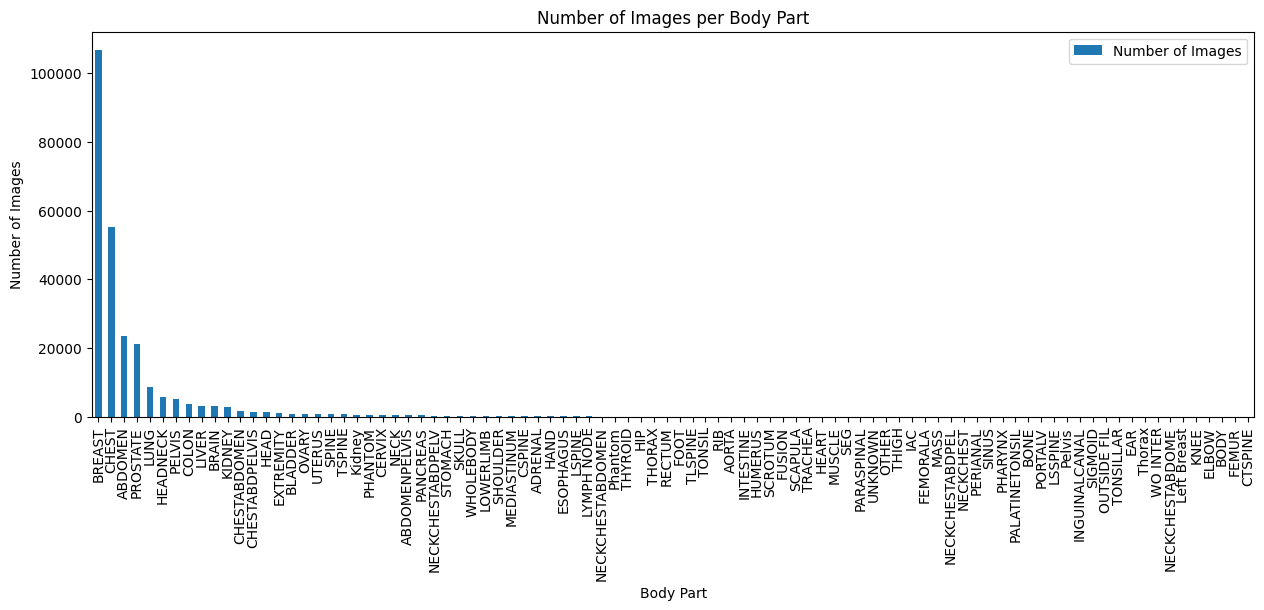

In [18]:
# Count number of images per body part
cancer_counts = df_api['BodyPartExamined'].value_counts().reset_index(name='Number of Images')
print(cancer_counts)

cancer_counts.plot(kind='bar', x='BodyPartExamined', y='Number of Images', title='Number of Images per Body Part', figsize=(15,5))
plt.xlabel('Body Part'); plt.ylabel('Number of Images'); plt.xticks(rotation=90)
plt.show()

                      Collection  Number of Images
0                          ISPY2             32411
1    Breast-Cancer-Screening-DBT             22032
2                          S0819             20181
3                     ACRIN-6698             18747
4                      PROSTATEx             18485
..                           ...               ...
144              QIN PET Phantom                44
145             RIDER Breast MRI                40
146                    TCGA-READ                34
147                    TCGA-SARC                33
148                    TCGA-THCA                28

[149 rows x 2 columns]


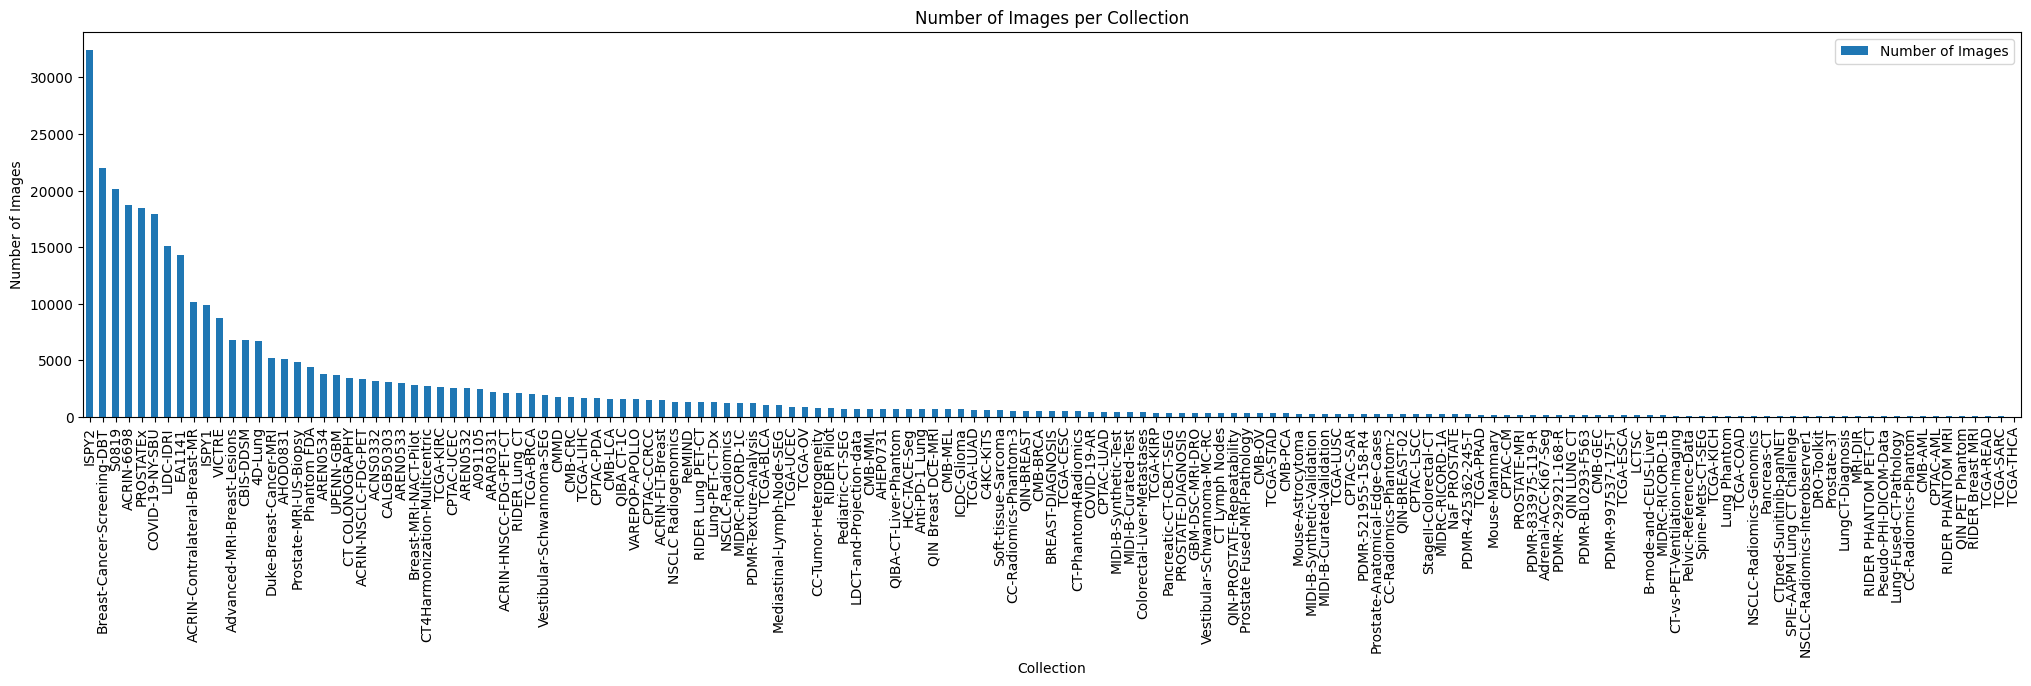

In [19]:
# Count number of images per Collection
cancer_counts = df_api['Collection'].value_counts().reset_index(name='Number of Images')
print(cancer_counts)

cancer_counts.plot(kind='bar', x='Collection', y='Number of Images', title='Number of Images per Collection', figsize=(25,5))
plt.xlabel('Collection'); plt.ylabel('Number of Images'); plt.xticks(rotation=90)
plt.show()

   BodyPartExamined  Number of Patients
0            BREAST               21753
1             CHEST                6729
2           ABDOMEN                3886
3            PELVIS                 977
4          PROSTATE                 967
..              ...                 ...
85           Pelvis                   1
86          TLSPINE                   1
87        TONSILLAR                   1
88           Thorax                   1
89         WO INTER                   1

[90 rows x 2 columns]


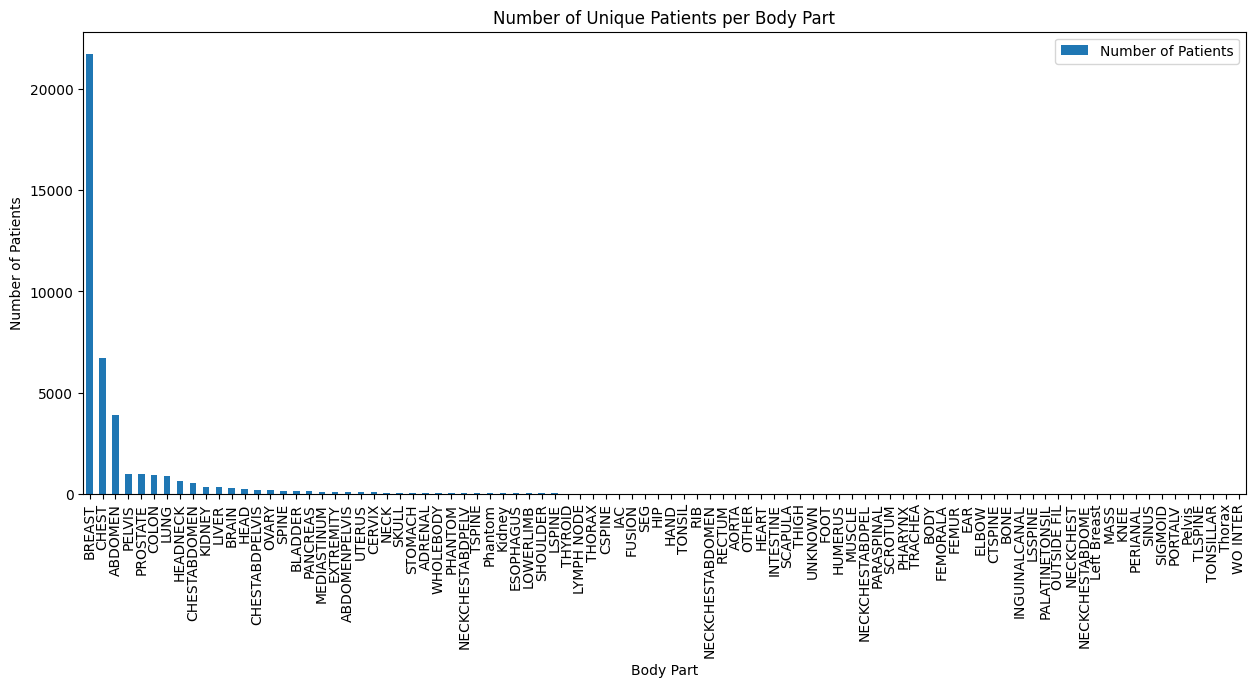

In [20]:
# Count number of patients per Body Part
patient_counts = df_api.groupby('BodyPartExamined')['PatientID'].nunique().sort_values(ascending=False).reset_index(name='Number of Patients')
print(patient_counts)

patient_counts.plot(kind='bar', x='BodyPartExamined', y='Number of Patients', title='Number of Unique Patients per Body Part', figsize=(15,6))
plt.xlabel('Body Part'); plt.ylabel('Number of Patients'); plt.xticks(rotation=90); plt.show()

                        Collection  Number of Patients
0                        CBIS-DDSM                6671
1      Breast-Cancer-Screening-DBT                5060
2                           VICTRE                2994
3                             CMMD                1775
4                  COVID-19-NY-SBU                1384
..                             ...                 ...
144                QIN PET Phantom                   2
145                   Lung Phantom                   1
146  CT4Harmonization-Multicentric                   1
147           CT-Phantom4Radiomics                   1
148                     QIBA CT-1C                   1

[149 rows x 2 columns]


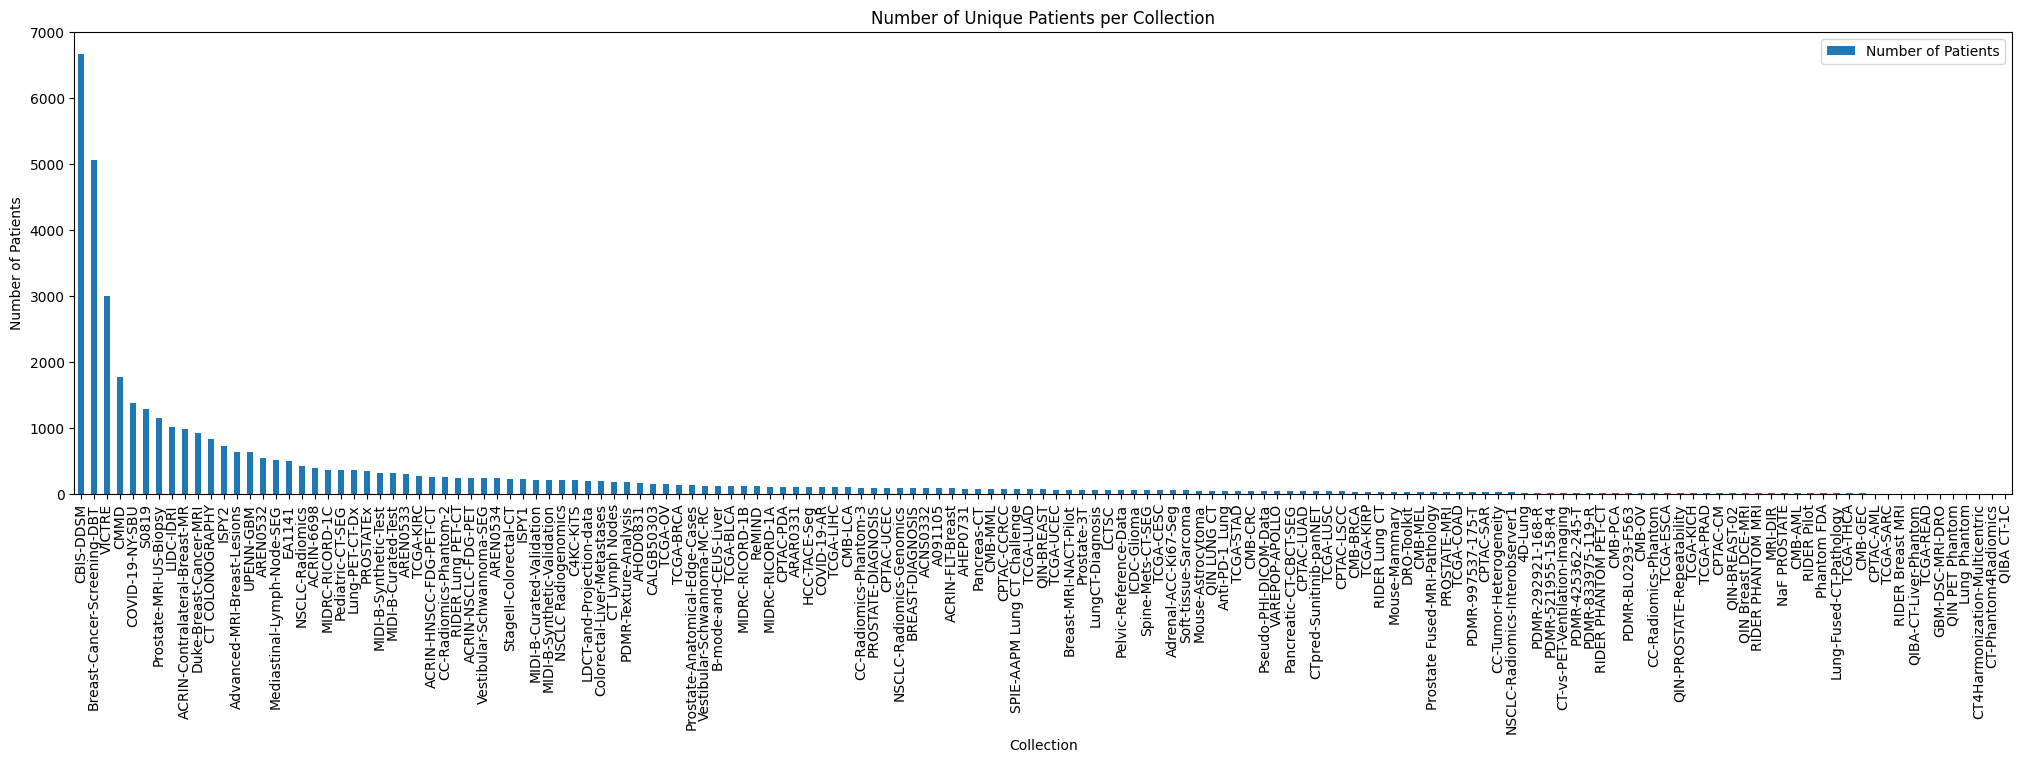

In [21]:
# Count number of patients per Collection
patient_counts = df_api.groupby('Collection')['PatientID'].nunique().sort_values(ascending=False).reset_index(name='Number of Patients')
print(patient_counts)

patient_counts.plot(kind='bar', x='Collection', y='Number of Patients', title='Number of Unique Patients per Collection', figsize=(25,6))
plt.xlabel('Collection'); plt.ylabel('Number of Patients'); plt.xticks(rotation=90); plt.show()

In [ ]:
# Now let's see how many unique Body Parts are there
print(len(df_api['BodyPartExamined'].unique())) 
print(df_api['BodyPartExamined'].unique())

91
['BREAST' 'KIDNEY' 'PROSTATE' 'Kidney' 'LIVER' 'EXTREMITY' nan 'HEAD'
 'UTERUS' 'CERVIX' 'LOWERLIMB' 'TSPINE' 'BLADDER' 'COLON' 'CHEST' 'OVARY'
 'STOMACH' 'ABDOMEN' 'MEDIASTINUM' 'PANCREAS' 'LUNG' 'WHOLEBODY'
 'Left Breast' 'CHESTABDPELVIS' 'OUTSIDE FIL' 'THYROID' 'RECTUM' 'THORAX'
 'PELVIS' 'ABDOMENPELVIS' 'ADRENAL' 'ESOPHAGUS' 'CHESTABDOMEN' 'IAC'
 'BRAIN' 'NECKCHESTABDPELV' 'PHANTOM' 'HEADNECK' 'CSPINE' 'OTHER' 'EAR'
 'UNKNOWN' 'Phantom' 'Thorax' 'NECK' 'HEART' 'SKULL' 'LSSPINE' 'SPINE'
 'LSPINE' 'FUSION' 'SEG' 'ELBOW' 'KNEE' 'Pelvis' 'SHOULDER' 'WO INTER'
 'FOOT' 'NECKCHESTABDOMEN' 'NECKCHEST' 'BODY' 'HIP' 'TLSPINE' 'FEMORALA'
 'TONSIL' 'LYMPH NODE' 'PORTALV' 'PHARYNX' 'SCROTUM' 'RIB' 'MUSCLE'
 'AORTA' 'HUMERUS' 'SIGMOID' 'PALATINETONSIL' 'TONSILLAR' 'INGUINALCANAL'
 'BONE' 'SCAPULA' 'PARASPINAL' 'THIGH' 'INTESTINE' 'NECKCHESTABDOME'
 'HAND' 'NECKCHESTABDPEL' 'TRACHEA' 'PERIANAL' 'MASS' 'SINUS' 'FEMUR'
 'CTSPINE']


# Obtaining a list of unique patient IDs (via the API), which can be used to query the Genomic Data Commons (GDC)

In [24]:
# Now let's see how many unique patient are there and 
# save a list of unique patient IDs which can be use to filter the Genomic Data Commons (GDC) data
print(len(df_api['PatientID'].unique())) 
print(df_api['PatientID'].unique())

df = pd.DataFrame(df_api['PatientID'].unique())
df.to_excel('patientIDs_tcia_api.xlsx', index=False, header=False)

39676
['ISPY1_1004' 'ISPY1_1005' 'ISPY1_1016' ... 'MSB-09146' 'MSB-01857'
 'ACNS0332_PARFPN']
